In [205]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import itertools
import json
from IPython.display import display as disp
from dateutil.parser import parse as dtparse

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
# import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]
mpl.rcParams['text.usetex'] = True

from importlib import reload as reloadmodule

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting, userActivityFunctions

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

mpl.rcParams['figure.figsize'] = [12, 7] 

In [226]:
COMPUTE_PCA = False

In [3]:
%config IPCompleter.use_jedi = False

In [4]:
mpl.rcParams['figure.figsize'] = [12, 7] 

# Load and clean data

In [5]:
df = pd.io.pytables.read_hdf('../../allan_data/phone_df.h5', 'df')
import pickle
with open('useralias.pk', 'br') as fid:
    ua = pickle.load(fid)
phonebook = loaders.loadUserPhonenumberDict(ua) 
df.head() 

body  duration  hour                                    number     timeint           timestamp  weekday
user  comtype                                                                                                        
u0001 call     NaN      29.0    15  36a4861f3f67cbf88b578d77743d1f5a8ddf604f  1386255771 2013-12-05 15:02:51        3
      call     NaN       0.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6  1386330792 2013-12-06 11:53:12        4
      call     NaN      89.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6  1386330838 2013-12-06 11:53:58        4
      call     NaN     104.0    13  36a4861f3f67cbf88b578d77743d1f5a8ddf604f  1386509631 2013-12-08 13:33:51        6
      call     NaN      32.0    18  36a4861f3f67cbf88b578d77743d1f5a8ddf604f  1386526906 2013-12-08 18:21:46        6

In [6]:
original_number_of_rows = df.shape[0] 

Remove call to users not in phonebook.

In [7]:
df = df[df.number.isin(phonebook)] 

Add _contactedUser_ column and remove the _number_ column.

In [8]:
df['contactedUser'] = df.number.apply(lambda x: phonebook[x]) 
df = df.drop('number', axis=1)

In [9]:
df.head() 

body  duration  hour     timeint           timestamp  weekday contactedUser
user  comtype                                                                            
u0001 call     NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493
      call     NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493
      call     NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117
      call     NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493
      call     NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117

In [10]:
df = df[df.timestamp >= '2013-07-01'] 

In [11]:
monthNameLookup = {1: 'Jan.', 2: 'Feb.', 3: 'Mar.', 4: 'Apr.', 5: 'May', 6: 'June',
                   7: 'July', 8: 'Aug.', 9: 'Sept.', 10: 'Oct.', 11: 'Nov.', 12: 'Dec.'}

grp = df.groupby([df.timestamp.dt.year, df.timestamp.dt.month]) 

In [12]:
# Change to to timeseries index
ddf = df.reset_index().set_index('timestamp')
ddf.index = pd.to_datetime(ddf.index)  # ensure that it's a timeseries... probably redundant

# ****************************************************************************
# *                   # Split into call and sms DataFrames                   *
# ****************************************************************************

# Call DataFrame
ddf_call = ddf.loc[ddf.comtype == 'call']  # make split
# Groupby and fix index: Yesr, Month -> timeseries
ddf_call = ddf_call.groupby([ddf_call.index.year, ddf_call.index.month]).timeint.count() 
ddf_call.index.names = ('year', 'month') 
idx_call = [dtparse(f"{year}/{month}") for (year, month) in
            zip(ddf_call.index.get_level_values(0), ddf_call.index.get_level_values(1))]
ddf_call.index = idx_call 
# Make it a DataFrame
ddf_call = pd.DataFrame(ddf_call)
ddf_call = ddf_call.rename(columns={'timeint': 'Call'})

# SMS DataFrame
ddf_sms = ddf.loc[ddf.comtype == 'sms']
# Groupby and fix index: Yesr, Month -> timeseries
ddf_sms = ddf_sms.groupby([ddf_sms.index.year, ddf_sms.index.month]).timeint.count()
ddf_sms.index.names = ('year', 'month') 
idx_sms = [dtparse(f"{year}/{month}") for (year, month) in
           zip(ddf_sms.index.get_level_values(0), ddf_sms.index.get_level_values(1))]
ddf_sms.index = idx_sms
# Make it a DataFrame
ddf_sms = pd.DataFrame(ddf_sms)
ddf_sms = ddf_sms.rename(columns={'timeint': 'SMS'})

# Join sms and call DataFrame
ddfc = ddf_call.join(ddf_sms)
del ddf_call, ddf_sms


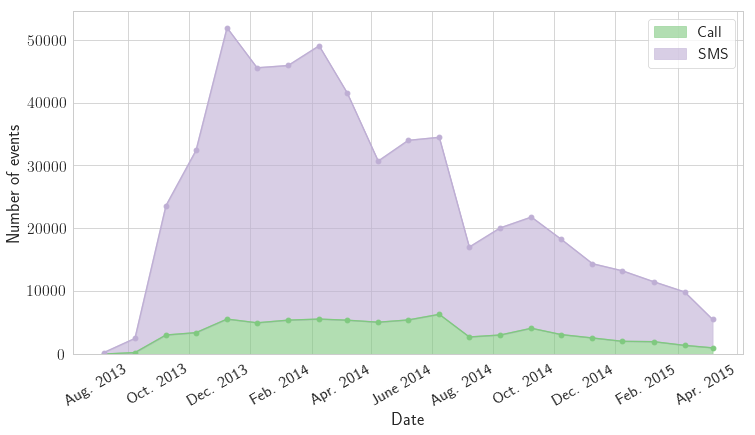

In [13]:
fig, ax = plt.subplots()
ddfc.plot.area(stacked=True, alpha=0.6, ax=ax)
fig.canvas.draw()

year, month = list(zip(*[el.get_text().split('-') for el in ax.get_xticklabels()]))
month = [monthNameLookup[int(mnt)] for mnt in month] 
xticks = [f"{month} {year}" for (year, month) in zip(year, month)]
ax.set_xticklabels(xticks); 

ddfc.Call.plot(marker='o', color=colorcycle[0], ax=ax)
ddfc.sum(axis=1).plot(marker='o', color=colorcycle[1], ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Number of events")
fig.canvas.draw() 
fig.savefig("figs/cleaned_call_and_sms_data_stacked_by_month.pdf")

Remove entries with users contacting themself

In [14]:
tmp = df.reset_index() 
tmp = tmp[(tmp.user != tmp.contactedUser)]
df = tmp.set_index(['user', 'comtype'], drop=False)
del tmp

In [15]:
df.head()

user comtype body  duration  hour     timeint           timestamp  weekday contactedUser
user  comtype                                                                                           
u0001 call     u0001    call  NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493
      call     u0001    call  NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493
      call     u0001    call  NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117
      call     u0001    call  NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493
      call     u0001    call  NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117

In [16]:
cleaned_number_of_rows = df.shape[0] 

In [17]:
original_number_of_rows

4922754

In [18]:
cleaned_number_of_rows

508811

This many percent data was discarded

In [19]:
(1 - cleaned_number_of_rows/original_number_of_rows)*100

89.66409859196702

In [20]:
n_call = df.xs('call', level=1).shape[0]
n_sms = df.xs('sms', level=1).shape[0]

n_sms / n_call

6.1591929197563005

# Finding cliques

NetworkX needs an undirected graph to find cliques, so that's what we'll construct.

We'll remove contacts with fewer than 3 communication events.

In [21]:
com = df.groupby('user').contactedUser.value_counts() 
com.head(12) 

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'user' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


user   contactedUser
u0001  u0493            121
       u0117             40
       u0783              6
       u0392              1
       u0791              1
u0002  u0796            108
       u0499             53
       u0287             30
       u0464             25
       u0592             23
       u0444             19
       u0211             18
Name: contactedUser, dtype: int64

In [22]:
com = com[com >= 3]

edges = com.index.tolist()

In [23]:
edges[:8]

[('u0001', 'u0493'),
 ('u0001', 'u0117'),
 ('u0001', 'u0783'),
 ('u0002', 'u0796'),
 ('u0002', 'u0499'),
 ('u0002', 'u0287'),
 ('u0002', 'u0464'),
 ('u0002', 'u0592')]

Construct the binary graph, find the cliques, and sort them by descending size, and remove cliques smaller than 3

In [24]:
g_dir = nx.DiGraph()
g_dir.add_edges_from(edges)

g_bin_rcp = g_dir.to_undirected(reciprocal=True)

In [25]:
cliques = pd.DataFrame([clq for clq in nx.algorithms.clique.find_cliques(g_bin_rcp) if len(clq) > 2])
cliques = cliques.iloc[np.argsort(cliques.count(axis=1))[::-1]]
cliques = cliques.reset_index(drop=True)
cliques.head() 

,0,1,2,3,4,5
0,u0993,u0388,u0683,u0446,u0618,u0645
1,u0324,u0287,u0128,u0758,u0951,None
2,u0228,u0813,u0176,u0544,u0568,None
3,u0724,u0705,u0393,u0128,u0758,None
4,u0324,u0287,u0128,u0477,u0951,None


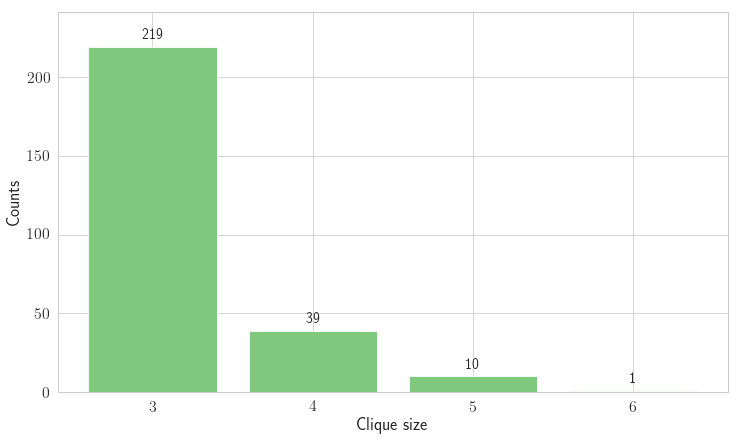

In [26]:
fig, ax = plt.subplots()
ax.bar([3,4,5,6], cliques.count(axis=1).value_counts())
ax.set_xlabel("Clique size")
ax.set_ylabel("Counts")
ax.set_xticks((3, 4, 5, 6))
plotting.looseAxesLimits(ax, (0, 0, 0, 0.05))
plotting.countsOnBarPlot(ax, fontsize=14)
fig.savefig("figs/clique_size_distribution_reciprocal.pdf")

In [27]:
g_bin = nx.Graph()
g_bin.add_edges_from(edges)
cliques = pd.DataFrame([clq for clq in nx.algorithms.clique.find_cliques(g_bin) if len(clq) > 2])
cliques = cliques.iloc[np.argsort(cliques.count(axis=1))[::-1]]
cliques = cliques.reset_index(drop=True)
cliques.head() 

,0,1,2,3,4,5,6
0,u0993,u0676,u0388,u0618,u0645,u0446,u0683
1,u0396,u0314,u0128,u0033,u0655,u0749,None
2,u0489,u0128,u0491,u0813,u0758,u0154,None
3,u0324,u0211,u0073,u0607,u0226,u0930,None
4,u0489,u0128,u0491,u0813,u0758,u0287,None


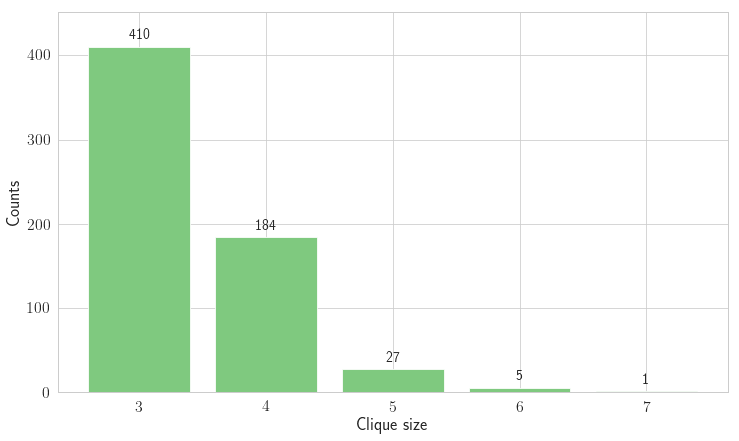

In [28]:
fig, ax = plt.subplots()
ax.bar([3,4,5,6,7], cliques.count(axis=1).value_counts())
ax.set_xlabel("Clique size")
ax.set_ylabel("Counts")
ax.set_xticks((3, 4, 5, 6, 7))
plotting.looseAxesLimits(ax, (0, 0, 0, 0.05))
plotting.countsOnBarPlot(ax, fontsize=14)
fig.savefig("figs/clique_size_distribution.pdf")

# Construct timebinned adjacency matrices for users, and do the stacking-PCA


### Determine start time offset for the binning 

Find the first occuring communication...

In [29]:
t0 = df.timestamp.min()
t0

Timestamp('2013-07-02 19:07:49')

…and choose the corresponding day...

In [30]:
t0d = pd.Timestamp(t0.date())
t0d

Timestamp('2013-07-02 00:00:00')

Since the timeint is in seconds, but Pandas keeps it's records in nanoseconds, the integer representation of the date needs to be divided by 1e9.

To check that this is indeed true, compare the values of the integer casted `t0` to the timeint for the corresponding row:

In [31]:
np.int64(t0.value // 1e9) == df.loc[df.timestamp.idxmin()].timeint.values[0]

True

Since it was true, use the following for the bin time start

In [32]:
t0d = np.int64(t0d.value // 1e9)
t0 = np.int64(t0.value // 1e9) 
t0d

1372723200

Binning is simply performed by integer division with a suiting bin width.
I choose 8 hours:

In [33]:
bw8h = 60**2*8
df['tbin'] = (df.timeint - t0d) // bw8h
df.head()

user comtype body  duration  hour     timeint           timestamp  weekday contactedUser  tbin
user  comtype                                                                                                 
u0001 call     u0001    call  NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493   624
      call     u0001    call  NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493   640
      call     u0001    call  NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117   661
      call     u0001    call  NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493   661
      call     u0001    call  NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117   766

Does it make sense to start the bins a midnight?

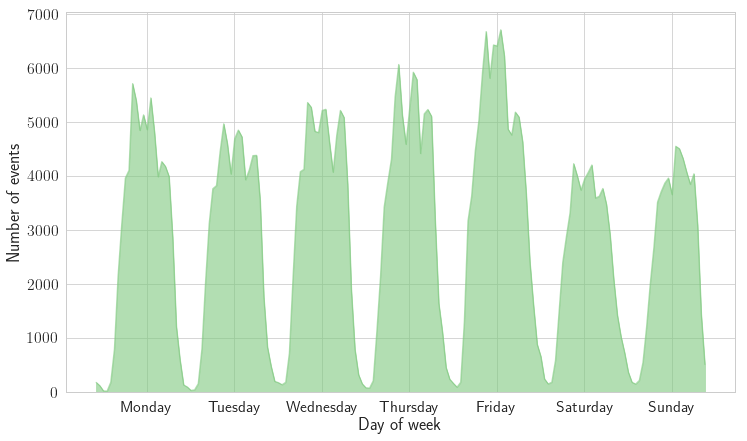

In [34]:
grp = df.groupby([df.timestamp.dt.dayofweek, df.timestamp.dt.hour]).timeint.count()  

grp.index = pd.TimedeltaIndex(freq='H', start=0, periods=24*7) 

fig, ax = plt.subplots()
grp.plot.area(alpha=0.6, ax=ax) 
ax.set_xticks( pd.TimedeltaIndex(freq='D', periods=7, start=0).values.astype(float)+5e13 )
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_ylabel("Number of events")
ax.set_xlabel("Day of week")
fig.savefig("figs/weekly_activity_by_hour.pdf")

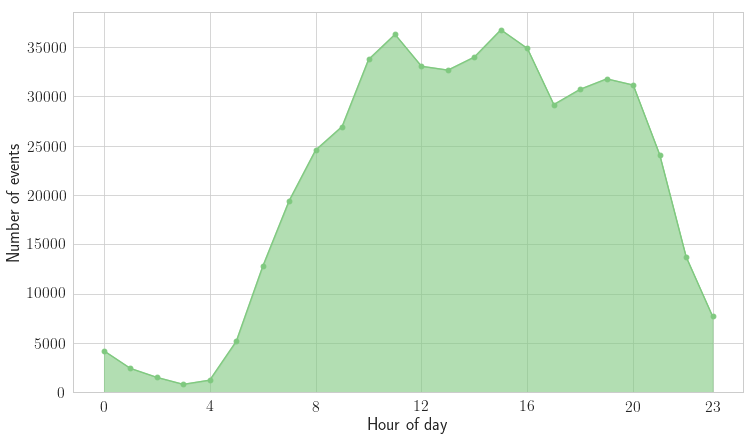

In [35]:
grp = df.groupby(df.timestamp.dt.hour).timeint.count() 
fig, ax = plt.subplots()
grp.plot.area(alpha=0.6, ax=ax) 
grp.plot(kind='line', color=colorcycle[0], style='-o', ax=ax) 
ax.set_xlabel("Hour of day")
ax.set_ylabel("Number of events")
ax.set_xticks([0, 4, 8, 12, 16, 20, 23]) 
fig.savefig("figs/dayly_events_by_hour.pdf") 

Test it with a 5-clique

In [77]:
tryout_clique = cliques[(cliques.count(axis=1) == 5)].iloc[0].dropna().tolist() 
print(*tryout_clique, sep='\t')

u0324	u0287	u0128	u0758	u0951


In [78]:
pca = userActivityFunctions.community2Pca(df, tryout_clique, 'tbin', nx.Graph)
print(f'pca.components_.shape : {pca.components_.shape}', sep='\n', end='\n\n')
print(f'pca.explained_variance_ratio_ : {pca.explained_variance_ratio_}', sep='\n', end='\n\n') 

pca.components_.shape : (10, 260)

pca.explained_variance_ratio_ : [3.22738175e-01 2.70515023e-01 1.00589738e-01 8.17579115e-02 5.70654875e-02 5.48477975e-02 4.59263879e-02 3.38746734e-02 3.26848059e-02
 5.55899312e-32]



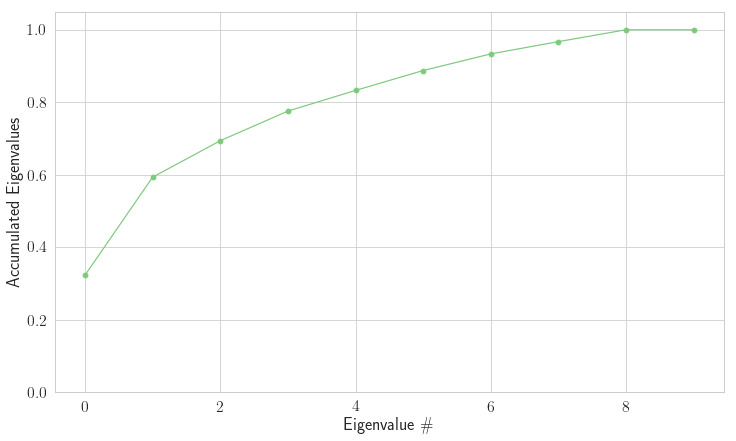

In [79]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_ylim([0, 1.05])
ax.set_xlabel("Eigenvalue \\#")
ax.set_ylabel("Accumulated Eigenvalues")
fig.savefig(f"figs/pca_{len(pca.community_)}_clique_undirected_eigenvalues_cumsum.pdf") 

The first 8 componentes explain 95 % of the variance — plotted below


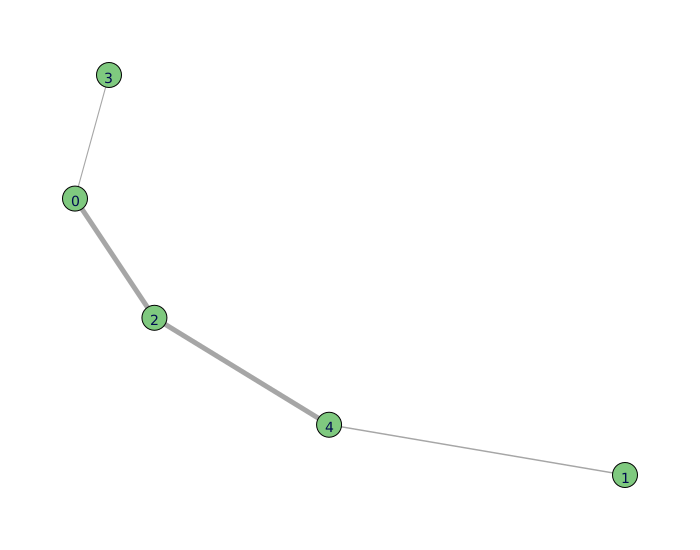

0.32273817544124606


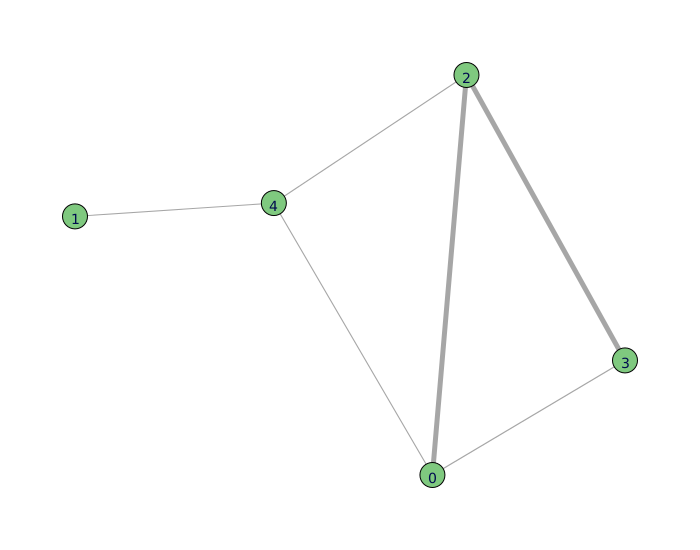

0.2705150225684049


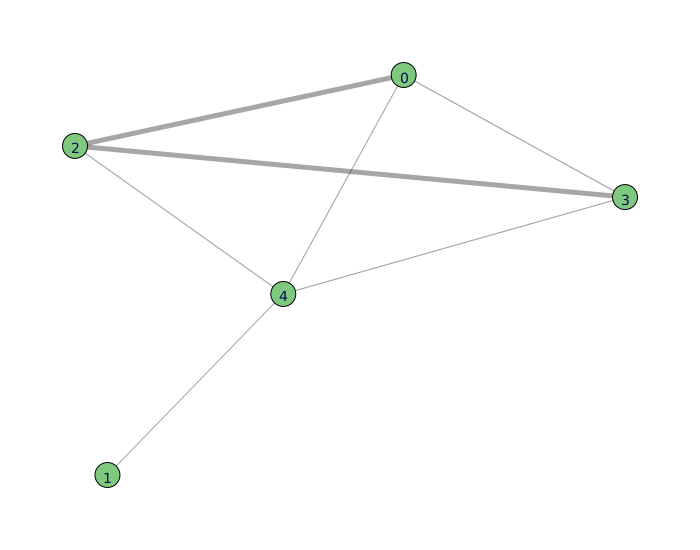

0.1005897383016659


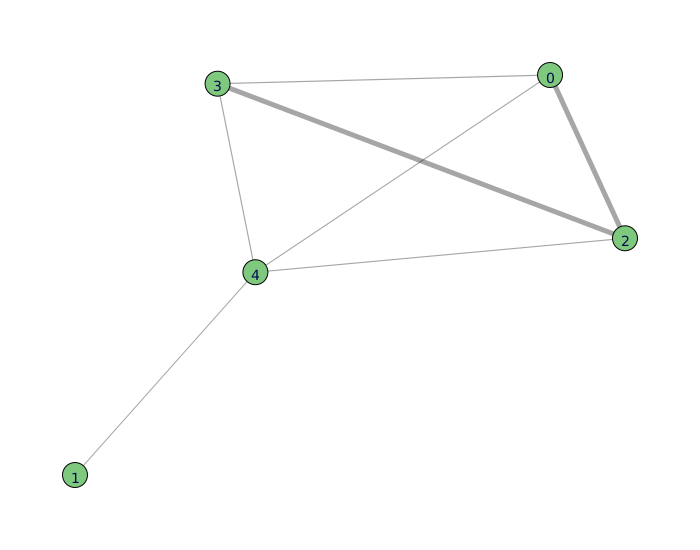

0.08175791146848543


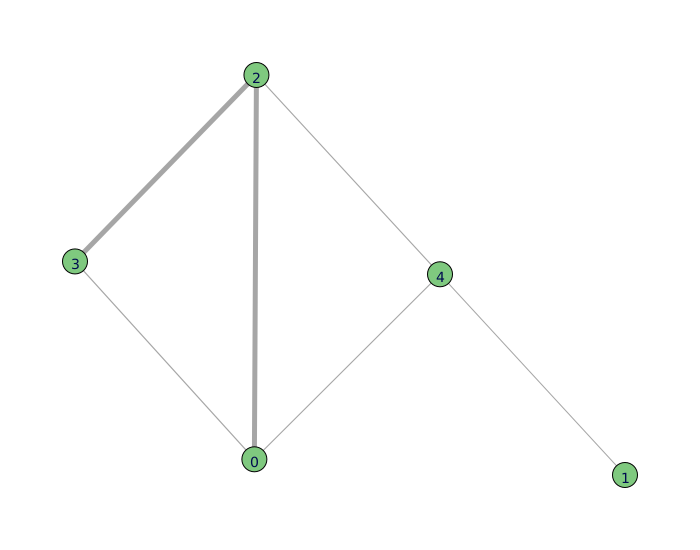

0.057065487513773355


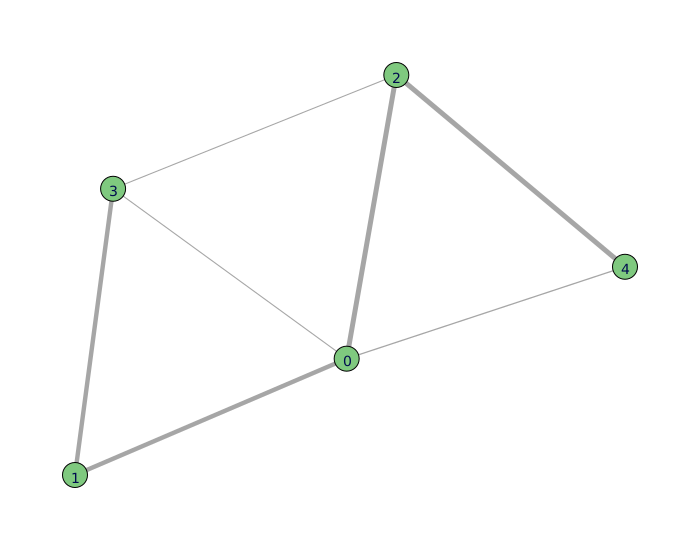

0.05484779746084717


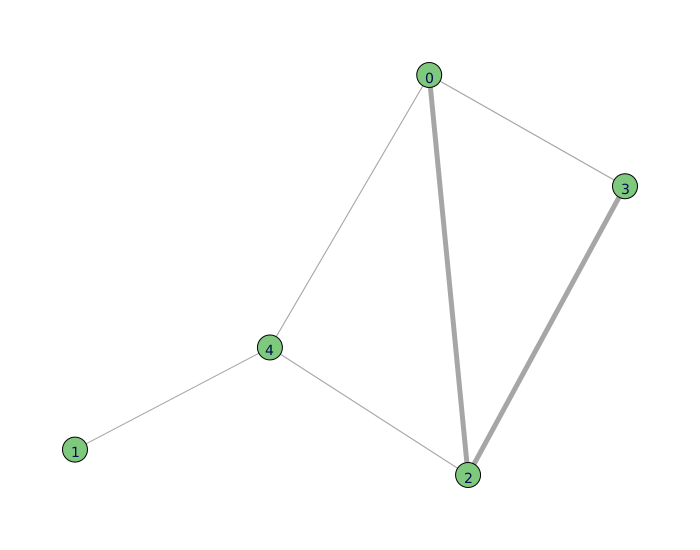

0.045926387945367866


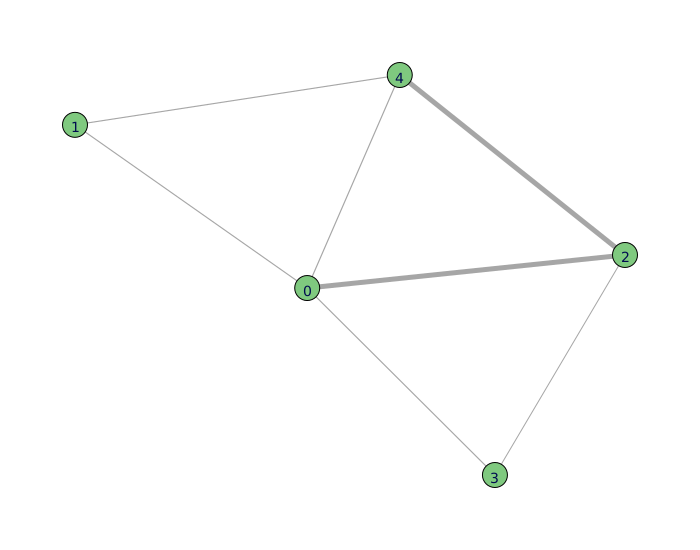

0.03387467341595712


In [81]:
n_to_plot = (np.cumsum(pca.explained_variance_ratio_) <= 0.95).sum() + 1
print(f"The first {n_to_plot} componentes explain 95 % of the variance — plotted below")
for i in range(n_to_plot):
    am = graph.upperTril2adjMat(pca.components_[:, i]) 
    am[am < 1e-5] = 0
    g_pca = nx.from_numpy_matrix(am)
    filename = f"figs/pca_graph_{len(pca.community_)}_undirected_clique_component_{i+1}_of_{n_to_plot}.pdf"
    disp(plotting.igdraw(g_pca, filename=filename))
    print(pca.explained_variance_ratio_[i])

Try with a directed graph

In [82]:
pca = userActivityFunctions.community2Pca(df, tryout_clique, 'tbin', nx.DiGraph, excludeDiagonal=True,
                                          fitFunctionKwargs={'performStandardization': True})
print(f'pca.components_.shape : {pca.components_.shape}', sep='\n', end='\n\n')
print(f'pca.explained_variance_ratio_ : {pca.explained_variance_ratio_}', sep='\n', end='\n\n')  

pca.components_.shape : (20, 260)

pca.explained_variance_ratio_ : [2.63340138e-01 2.24845762e-01 8.12269258e-02 6.90061872e-02 6.54145433e-02 5.28833558e-02 4.81080789e-02 3.96816169e-02 3.86254641e-02
 2.92238310e-02 2.77956658e-02 2.06902031e-02 1.46699336e-02 7.74470154e-03 5.77092137e-03 3.84697901e-03 3.59907813e-03 2.13642602e-03
 1.39018840e-03 3.38613063e-32]



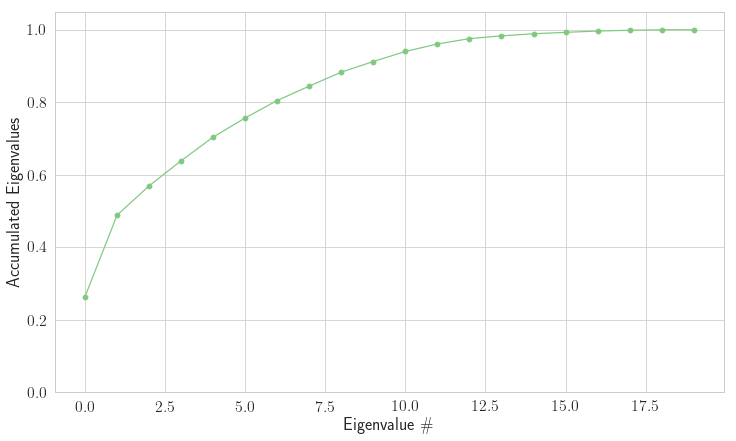

In [84]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_ylim([0, 1.05])
ax.set_xlabel("Eigenvalue \\#")
ax.set_ylabel("Accumulated Eigenvalues")
fig.savefig(f"figs/pca_{len(pca.community_)}_clique_directed_eigenvalues_cumsum.pdf") 

The first 12 componentes explain 95 % of the variance — plotted below


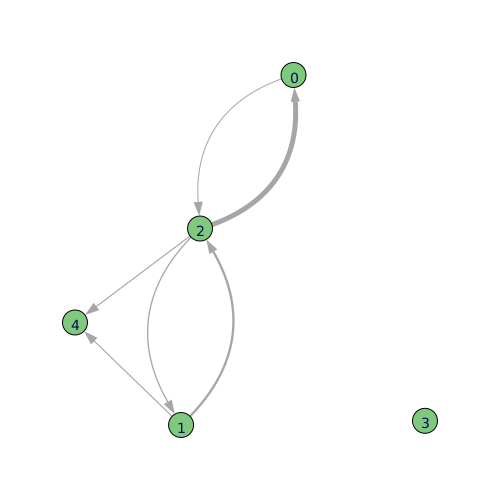

0.26334013812703266


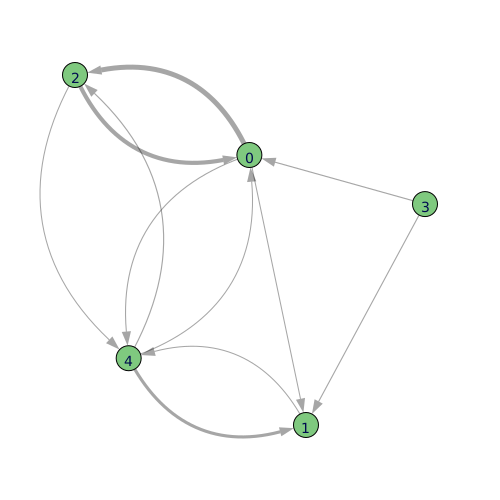

0.22484576190298294


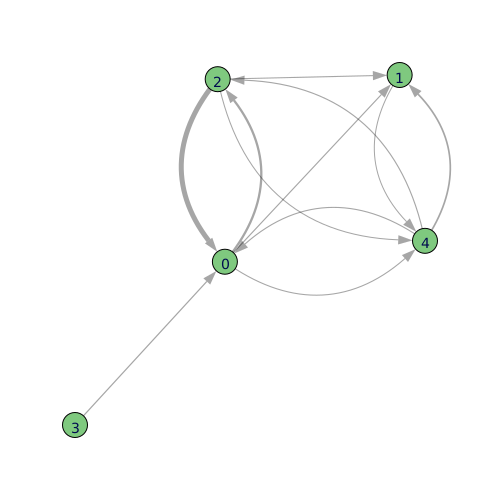

0.08122692583821517


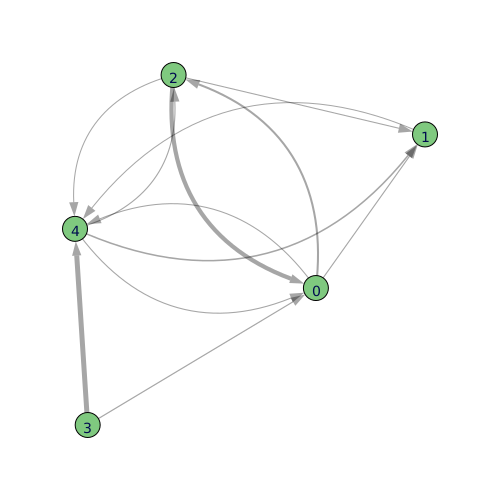

0.06900618724299423


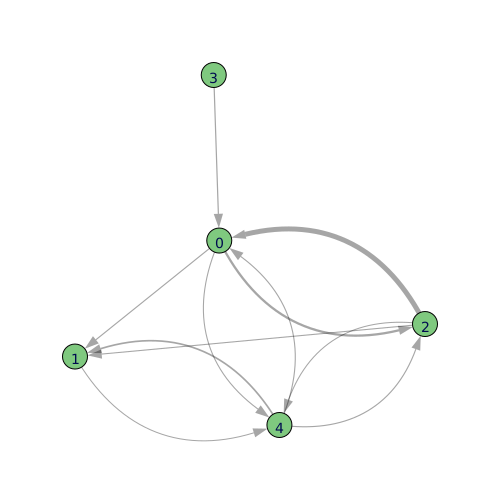

0.06541454325660179


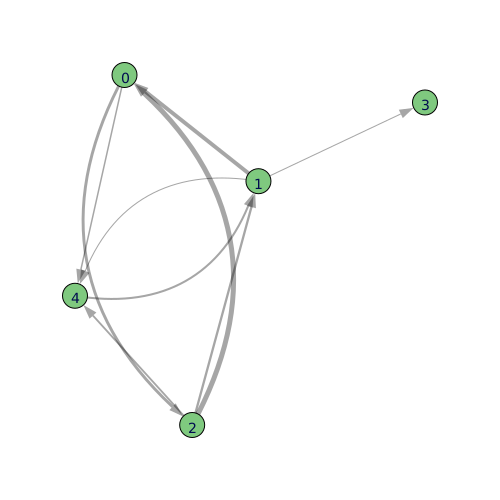

0.05288335580877957


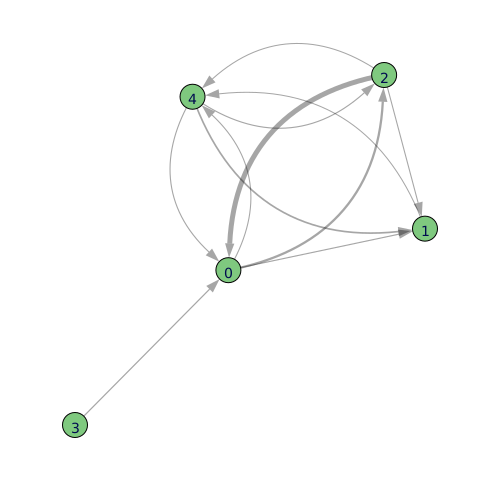

0.048108078884468594


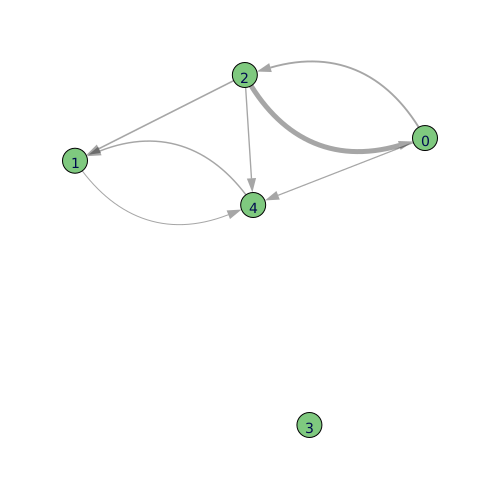

0.039681616867059746


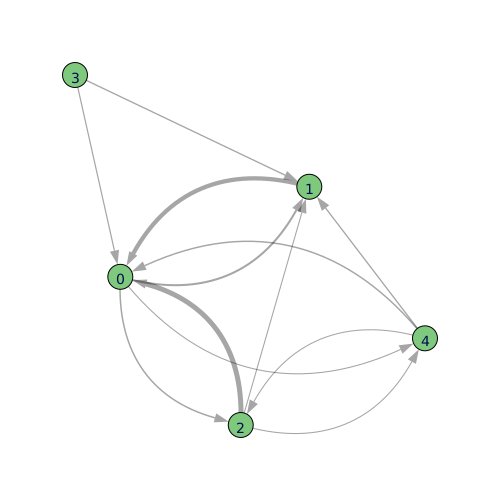

0.03862546406810666


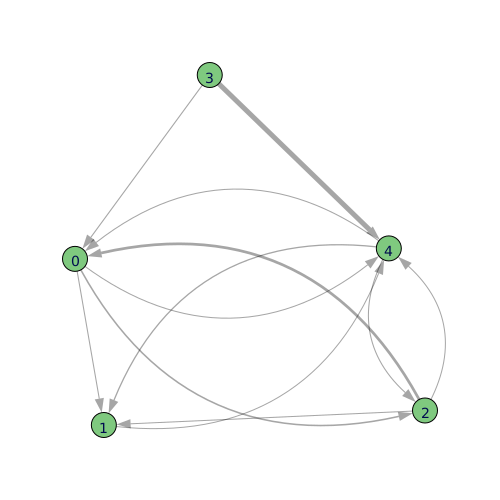

0.029223831045665387


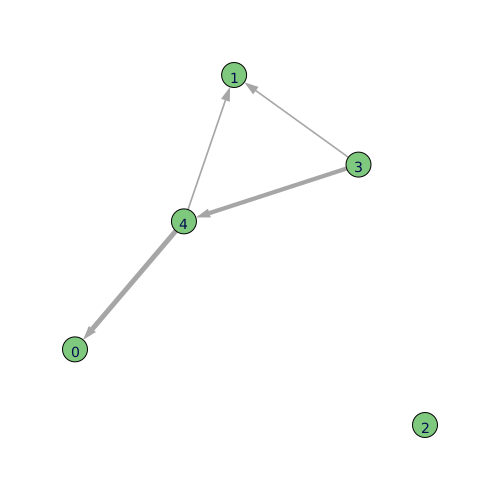

0.027795665812908554


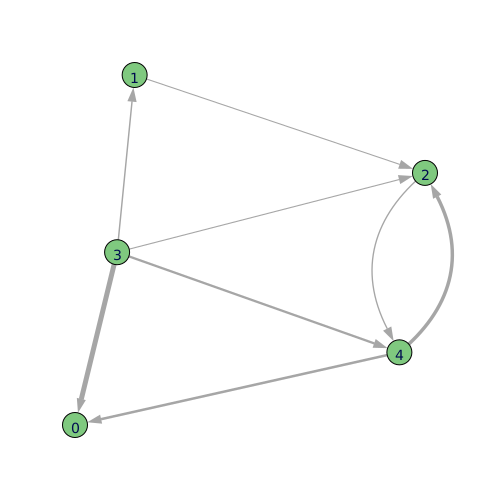

0.020690203068002466


In [83]:
n_to_plot = (np.cumsum(pca.explained_variance_ratio_) <= 0.95).sum() + 1
print(f"The first {n_to_plot} componentes explain 95 % of the variance — plotted below") 
for i in range(n_to_plot):
    am = graph.vec2squareMat(pca.components_[:, i], addDiagonal=True) 
    # amorg = am.copy() 
    # am += np.abs(am.min())
    # am[np.eye(am.shape[0], dtype=bool)] = 0  # make the diagonal 0 again
    # am[am < am.max()/100] = 0
    am[am < 1e-5] = 0
    g_pca = nx.from_numpy_matrix(am, create_using=nx.DiGraph())
    filename = f"figs/pca_graph_{len(pca.community_)}_directed_clique_component_{i+1}_of_{n_to_plot}.pdf"
    disp(plotting.igdraw(g_pca, filename=filename, bbox=(500, 500)))
    print(pca.explained_variance_ratio_[i])

# Do it for _all_ cliques

Args for multiprocessing.

Since the arguments symmetric = True/False are monkay-patched onto the PCA object, we can easily identify what we whether a Graph or DiGraph was used to create the adjacency matrices in use.

In [50]:
try:
    del args_lst
except NameError:
    pass

args_lst = list()
for ri, row in cliques.iterrows():
    clq = row.dropna().tolist()
    
    args = (
    df,           #  userDf
    clq,          #  community
    'tbin',       #  binColumn
    nx.DiGraph,   #  graphtype
    False,        #  excludeDiagonal
    misc.pcaFit,  #  fitFunction
    None,         #  fitFunctionKwargs
    -ri           #  printProgress
    )
    args_lst.append(args)

    args = (
    df,           #  userDf
    clq,          #  community
    'tbin',       #  binColumn
    nx.Graph,     #  graphtype
    False,        #  excludeDiagonal
    misc.pcaFit,  #  fitFunction
    None,         #  fitFunctionKwargs
    ri            #  printProgress
    )
    args_lst.append(args) 

In [51]:
len(args_lst)

1254

In [53]:
pca = userActivityFunctions.community2Pca(*args_lst[-1])
pca

Clique number 626 processed, members: ('u0243', 'u0529', 'u0571')


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Seems to work when evaluated on the local Python process

In [54]:
if COMPUTE_PCA:
    with multiprocessing.Pool(processes=30) as pool:
        pca_result_pool = pool.starmap(userActivityFunctions.community2Pca, args_lst)

Clique number -66 processed, members: ('u0325', 'u0418', 'u0630', 'u0017')
Clique number 82 processed, members: ('u0550', 'u0322', 'u0071', 'u0431')
Clique number 27 processed, members: ('u0228', 'u0318', 'u0176', 'u0544', 'u0568')
Clique number 16 processed, members: ('u0324', 'u0211', 'u0073', 'u0392', 'u0146')
Clique number -88 processed, members: ('u0122', 'u0656', 'u0889', 'u0073')
Clique number -99 processed, members: ('u0122', 'u0392', 'u0117', 'u0493')
Clique number -22 processed, members: ('u0122', 'u0392', 'u0117', 'u0264', 'u0739')
Clique number 5 processed, members: ('u0324', 'u0287', 'u0128', 'u0758', 'u0491', 'u0813')
Clique number 49 processed, members: ('u0149', 'u0011', 'u0768', 'u0202')
Clique number -33 processed, members: ('u0638', 'u0226', 'u0583', 'u0808')
Clique number 60 processed, members: ('u0687', 'u0448', 'u0464', 'u1033')
Clique number 93 processed, members: ('u0681', 'u0361', 'u0859', 'u0648')
Clique number -44 processed, members: ('u0233', 'u0808', 'u0583

Clique number 89 processed, members: ('u0189', 'u1014', 'u0543', 'u0995')
Clique number -101 processed, members: ('u0122', 'u0392', 'u0073', 'u0889')
Clique number 28 processed, members: ('u0122', 'u0392', 'u0241', 'u0264', 'u0739')
Clique number -7 processed, members: ('u0228', 'u0813', 'u0758', 'u0128', 'u0287')
Clique number 64 processed, members: ('u0325', 'u0418', 'u1042', 'u0017')
Clique number -95 processed, members: ('u0233', 'u0564', 'u0777', 'u0214')
Clique number 143 processed, members: ('u0324', 'u0287', 'u0996', 'u0444')
Clique number 154 processed, members: ('u0418', 'u0017', 'u0741', 'u0608')
Clique number 69 processed, members: ('u0002', 'u0287', 'u0444', 'u0612')
Clique number -36 processed, members: ('u1037', 'u0139', 'u0217', 'u0589')
Clique number -40 processed, members: ('u0335', 'u0893', 'u0896', 'u0193')
Clique number -46 processed, members: ('u0278', 'u0844', 'u0612', 'u0884')
Clique number 55 processed, members: ('u0235', 'u0369', 'u0496', 'u0792')
Clique numbe

Clique number 75 processed, members: ('u0083', 'u0256', 'u0343', 'u0865')
Clique number -173 processed, members: ('u0436', 'u0461', 'u0535', 'u0907')
Clique number -59 processed, members: ('u0743', 'u0318', 'u0808', 'u0400')
Clique number 124 processed, members: ('u0889', 'u0073', 'u0226', 'u0656')
Clique number -20 processed, members: ('u0889', 'u0073', 'u0226', 'u0930', 'u0607')
Clique number 167 processed, members: ('u0324', 'u0226', 'u0583', 'u0607')
Clique number 162 processed, members: ('u0590', 'u0704', 'u0688', 'u0305')
Clique number 59 processed, members: ('u0743', 'u0318', 'u0808', 'u0400')
Clique number 176 processed, members: ('u0489', 'u0128', 'u0491', 'u0655')
Clique number -109 processed, members: ('u0122', 'u0884', 'u0844', 'u0612')
Clique number -131 processed, members: ('u0086', 'u0409', 'u0478', 'u0271')
Clique number 96 processed, members: ('u0681', 'u0193', 'u0859', 'u0893')
Clique number -93 processed, members: ('u0681', 'u0361', 'u0859', 'u0648')
Clique number -4

Clique number 215 processed, members: ('u0590', 'u0662', 'u0137', 'u0288')
Clique number 13 processed, members: ('u0419', 'u0574', 'u0206', 'u0986', 'u0992')
Clique number -182 processed, members: ('u0152', 'u0794', 'u0801', 'u0885')
Clique number 120 processed, members: ('u0057', 'u0420', 'u0311', 'u0824')
Clique number 225 processed, members: ('u0784', 'u0692', 'u1000')
Clique number -81 processed, members: ('u0122', 'u0656', 'u0264', 'u0241')
Clique number 189 processed, members: ('u0786', 'u0226', 'u0808', 'u0583')
Clique number -158 processed, members: ('u0324', 'u0287', 'u0318', 'u0798')
Clique number -209 processed, members: ('u0472', 'u0045', 'u1031', 'u0288')
Clique number -179 processed, members: ('u0441', 'u0287', 'u0996', 'u0444')
Clique number -25 processed, members: ('u0993', 'u1001', 'u0743', 'u0530', 'u0292')
Clique number 81 processed, members: ('u0122', 'u0656', 'u0264', 'u0241')
Clique number 193 processed, members: ('u0250', 'u0285', 'u0364', 'u0279')
Clique number 

Clique number -10 processed, members: ('u0324', 'u0073', 'u0503', 'u0392', 'u0146')
Clique number -180 processed, members: ('u0441', 'u0287', 'u0477', 'u0444')
Clique number -276 processed, members: ('u0779', 'u0071', 'u0504')
Clique number -195 processed, members: ('u0250', 'u0224', 'u0364', 'u0279')
Clique number 234 processed, members: ('u0726', 'u0265', 'u0051')
Clique number -16 processed, members: ('u0324', 'u0211', 'u0073', 'u0392', 'u0146')
Clique number 241 processed, members: ('u0240', 'u0405', 'u0812')
Clique number -272 processed, members: ('u0515', 'u0071', 'u0588')
Clique number -264 processed, members: ('u0130', 'u0197', 'u0628')
Clique number -235 processed, members: ('u0248', 'u0284', 'u0947')
Clique number -243 processed, members: ('u0167', 'u0923', 'u0737')
Clique number 224 processed, members: ('u0216', 'u0567', 'u0451')
Clique number 206 processed, members: ('u0472', 'u0045', 'u0440', 'u0253')
Clique number -244 processed, members: ('u0784', 'u0214', 'u0051')
Cliqu

Clique number 267 processed, members: ('u0122', 'u0236', 'u0292')
Clique number -322 processed, members: ('u0473', 'u0033', 'u0116')
Clique number 299 processed, members: ('u0149', 'u0011', 'u0747')
Clique number 208 processed, members: ('u0324', 'u0214', 'u0607', 'u0146')
Clique number 261 processed, members: ('u0152', 'u0543', 'u0801')
Clique number 323 processed, members: ('u0694', 'u0404', 'u0233')
Clique number 322 processed, members: ('u0473', 'u0033', 'u0116')
Clique number -300 processed, members: ('u0140', 'u0820', 'u0256')
Clique number 257 processed, members: ('u0383', 'u1056', 'u0004')
Clique number 300 processed, members: ('u0140', 'u0820', 'u0256')
Clique number 307 processed, members: ('u0571', 'u0376', 'u0342')
Clique number -262 processed, members: ('u0908', 'u0808', 'u0506')
Clique number -301 processed, members: ('u0942', 'u0457', 'u0290')
Clique number -323 processed, members: ('u0694', 'u0404', 'u0233')
Clique number -314 processed, members: ('u0083', 'u0256', 'u03

Clique number -363 processed, members: ('u0885', 'u0818', 'u0287')
Clique number 363 processed, members: ('u0885', 'u0818', 'u0287')
Clique number 186 processed, members: ('u0786', 'u0226', 'u0808', 'u0183')
Clique number -203 processed, members: ('u0324', 'u0314', 'u0655', 'u0128')
Clique number 295 processed, members: ('u0571', 'u0613', 'u0529')
Clique number -364 processed, members: ('u0126', 'u0129', 'u0431')
Clique number 345 processed, members: ('u0455', 'u0053', 'u0259')
Clique number 352 processed, members: ('u0779', 'u0859', 'u0140')
Clique number -296 processed, members: ('u0673', 'u0625', 'u0350')
Clique number 318 processed, members: ('u0473', 'u0122', 'u0612')
Clique number 368 processed, members: ('u0571', 'u1023', 'u0441')
Clique number 364 processed, members: ('u0126', 'u0129', 'u0431')
Clique number 296 processed, members: ('u0673', 'u0625', 'u0350')
Clique number -353 processed, members: ('u0974', 'u0786', 'u0171')
Clique number -346 processed, members: ('u0235', 'u03

Clique number 373 processed, members: ('u0540', 'u0239', 'u0063')
Clique number 414 processed, members: ('u0924', 'u0601', 'u0378')
Clique number -197 processed, members: ('u0228', 'u0813', 'u0544', 'u0211')
Clique number -435 processed, members: ('u0200', 'u0601', 'u0274')
Clique number -388 processed, members: ('u0612', 'u0601', 'u0690')
Clique number 408 processed, members: ('u0769', 'u0723', 'u0781')
Clique number -440 processed, members: ('u0017', 'u0881', 'u0630')
Clique number -360 processed, members: ('u0246', 'u0271', 'u0033')
Clique number 420 processed, members: ('u0969', 'u0391', 'u0920')
Clique number -421 processed, members: ('u0979', 'u0132', 'u0267')
Clique number 435 processed, members: ('u0200', 'u0601', 'u0274')
Clique number 429 processed, members: ('u0574', 'u0920', 'u0391')
Clique number -430 processed, members: ('u0378', 'u0848', 'u0206')
Clique number 430 processed, members: ('u0378', 'u0848', 'u0206')
Clique number 440 processed, members: ('u0017', 'u0881', 'u0

Clique number 484 processed, members: ('u0176', 'u0318', 'u0656')
Clique number -468 processed, members: ('u0264', 'u0719', 'u0392')
Clique number -485 processed, members: ('u0176', 'u0318', 'u0400')
Clique number 485 processed, members: ('u0176', 'u0318', 'u0400')
Clique number 428 processed, members: ('u0574', 'u0424', 'u0986')
Clique number 468 processed, members: ('u0264', 'u0719', 'u0392')
Clique number 439 processed, members: ('u0256', 'u0073', 'u0225')
Clique number -476 processed, members: ('u0241', 'u0930', 'u0264')
Clique number -486 processed, members: ('u0176', 'u0981', 'u0400')
Clique number 427 processed, members: ('u0262', 'u1058', 'u1045')
Clique number 486 processed, members: ('u0176', 'u0981', 'u0400')
Clique number -495 processed, members: ('u0423', 'u0441', 'u0951')
Clique number 476 processed, members: ('u0241', 'u0930', 'u0264')
Clique number -428 processed, members: ('u0574', 'u0424', 'u0986')
Clique number -465 processed, members: ('u0005', 'u0348', 'u1054')
Cli

Clique number -541 processed, members: ('u0927', 'u0287', 'u0624')
Clique number -545 processed, members: ('u1010', 'u0541', 'u0581')
Clique number 550 processed, members: ('u0729', 'u0292', 'u0743')
Clique number -551 processed, members: ('u0773', 'u0318', 'u0610')
Clique number -535 processed, members: ('u0568', 'u0588', 'u0859')
Clique number 551 processed, members: ('u0773', 'u0318', 'u0610')
Clique number 545 processed, members: ('u1010', 'u0541', 'u0581')
Clique number 566 processed, members: ('u0330', 'u0583', 'u0576')
Clique number -552 processed, members: ('u0773', 'u0318', 'u0517')
Clique number 555 processed, members: ('u0762', 'u0639', 'u0939')
Clique number -543 processed, members: ('u0628', 'u0995', 'u0279')
Clique number 552 processed, members: ('u0773', 'u0318', 'u0517')
Clique number -556 processed, members: ('u0762', 'u0638', 'u0183')
Clique number 470 processed, members: ('u0586', 'u0919', 'u0506')
Clique number -567 processed, members: ('u1035', 'u0225', 'u0343')
Cl

Clique number 592 processed, members: ('u0263', 'u0610', 'u0961')
Clique number -616 processed, members: ('u0233', 'u0404', 'u0674')
Clique number 600 processed, members: ('u0290', 'u0276', 'u0843')
Clique number 616 processed, members: ('u0233', 'u0404', 'u0674')
Clique number -594 processed, members: ('u0182', 'u0226', 'u0808')
Clique number 594 processed, members: ('u0182', 'u0226', 'u0808')
Clique number -595 processed, members: ('u1035', 'u0424', 'u1022')
Clique number -593 processed, members: ('u0263', 'u0642', 'u0068')
Clique number -617 processed, members: ('u0233', 'u0674', 'u0886')
Clique number 617 processed, members: ('u0233', 'u0674', 'u0886')
Clique number 610 processed, members: ('u0376', 'u1046', 'u0002')
Clique number -601 processed, members: ('u0754', 'u0810', 'u0641')
Clique number 595 processed, members: ('u1035', 'u0424', 'u1022')
Clique number -608 processed, members: ('u0376', 'u0361', 'u1046')
Clique number -618 processed, members: ('u0233', 'u0711', 'u0886')
Cl

Count datatypes: All seem to be PCA, which meant that none of the jobs raised a `ValueError`, in which case the result should be `np.NaN`, which have type `float`.

In [55]:
if COMPUTE_PCA:
    Counter(type(el) for el in pca_result_pool)

Counter({sklearn.decomposition.pca.PCA: 1254})

Get communities in the order thay're saved in the pool-result

In [227]:
if COMPUTE_PCA:
    communities = [pca.community_ for pca in pca_result_pool]

Save the results to a DataFrame

In [86]:
if COMPUTE_PCA:
    pcadf = pd.DataFrame([pca_result_pool, communities], index="pca clique".split()).T
    pcadf = pcadf.iloc[np.argsort(pcadf.clique.map(len))[::-1]]
    pcadf['symmetric'] = pcadf.pca.map(lambda x: x.symmetric_) 
    pcadf['n_clique'] = pcadf.clique.map(len)
    pcadf.head() 
else:
    try:  # is pcadf alreaddy defined?
        pcadf.dtypes()
    except NameError:  # it wasn't, so load it if the file exists
        if os.path.isfile('../../allan_data/pca_cliques_second_take_results.hdfstore'):
            with pd.HDFStore('../../allan_data/pca_cliques_second_take_results.hdfstore') as store:
                pcadf = store['pcadf']
    

,pca,clique,symmetric,n_clique
0,"PCA(copy=True, iterated_power='auto', n_compon...","(u0993, u0676, u0388, u0618, u0645, u0446, u0683)",False,7
1,"PCA(copy=True, iterated_power='auto', n_compon...","(u0993, u0676, u0388, u0618, u0645, u0446, u0683)",True,7
6,"PCA(copy=True, iterated_power='auto', n_compon...","(u0324, u0211, u0073, u0607, u0226, u0930)",False,6
10,"PCA(copy=True, iterated_power='auto', n_compon...","(u0324, u0287, u0128, u0758, u0491, u0813)",False,6
9,"PCA(copy=True, iterated_power='auto', n_compon...","(u0489, u0128, u0491, u0813, u0758, u0287)",True,6


And save the DataFrame as a Pandas HDFStore

In [228]:
if COMPUTE_PCA:  # No need to save the PCA results to a file, unless it was re-computed.
    with pd.HDFStore('../../allan_data/pca_cliques_second_take_results.hdfstore') as store:
        store['pcadf'] = pcadf

# Apply clustering algorithms

* Perform some clustering with different algorithms
* Project to 2D using t-sne
    - Colorize cluster with results from high dimmensional clustering algorithms
    - Try different valus for t-sne perplexity, and describe whet they do
* Consider trying UMAP

### Collect the vectors for the graphs of differet clique sizes

Split collections based on directed or undirected graphs, and on clique size

In [108]:
pcadf.n_clique.value_counts() // 2  # divided by 2 because we separate directed and undirected graphs

3    410
4    184
5     27
6      5
7      1
Name: n_clique, dtype: int64

In [109]:
mask = pcadf.symmetric & (pcadf.n_clique == 5)

In [121]:
lst_components = list()
lst_index = list()
for ipca in pcadf[mask].pca:
    n_components = (np.cumsum(ipca.explained_variance_ratio_) <= 0.95).sum()
    to_append = ipca.components_[:, :n_components]
    lst_components.append(to_append)
    lst_index.append(np.arange(n_components)) 

In [122]:
pca.components_.shape

(20, 260)

In [128]:
clique_mode = np.concatenate(lst_components, axis=1).T
clique_index = np.concatenate(lst_index)

### Plot using t-SNE

Apple t-SNE and plot the vectors

In [176]:
from sklearn import manifold
from sklearn import cluster
from hdbscan import HDBSCAN

In [166]:
tsne = manifold.TSNE(perplexity=30)
data_tsne = tsne.fit_transform(clique_mode)

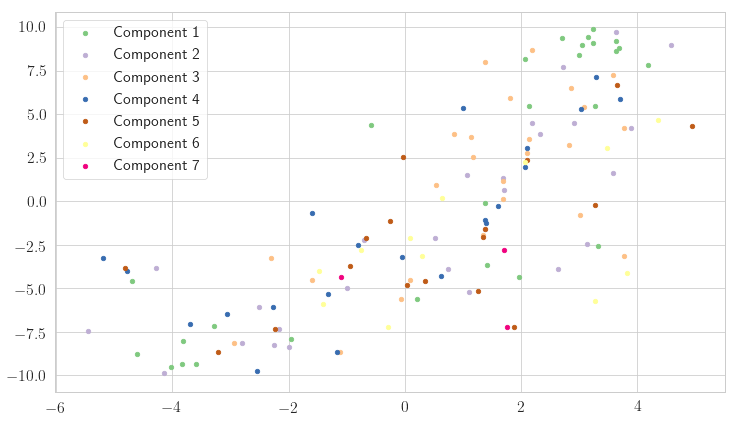

In [180]:
fig, ax = plt.subplots()
for i in pd.unique(clique_index):
    ax.scatter(*data_tsne[clique_index == i].T, s=20, color=colorcycle[i], label=f"Component {i+1}") 
ax.legend(loc='upper left') 
fig.savefig(f"figs/tsne_componnts_perp_30_colored_5_clique_directed.pdf")

Try clustering the points with different algorithms

In [181]:
pd.value_counts(clique_index)

1    27
0    27
2    25
3    21
4    17
5    12
6     3
dtype: int64

In [ ]:
clstData = misc.standardizeData(clique_mode) 

#### KMeans

In [182]:
kmeans = cluster.KMeans(max_iter=1000, n_jobs=16, n_clusters=6) 
kmeans.fit(clstData)
clst = kmeans.fit_predict(clstData)
np.unique(clst, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([ 8, 22, 46,  6, 48,  2]))

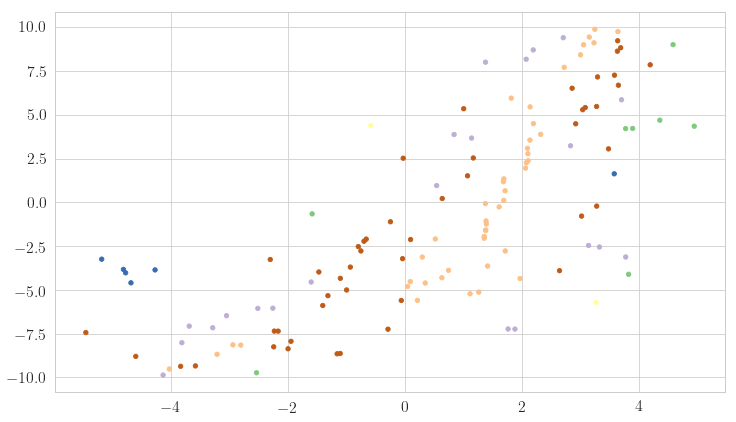

In [184]:
fig, ax = plt.subplots()
ax.scatter(*data_tsne.T, s=20, c=[colorcycle[i] for i in clst], label=f"Component {i+1}") 
fig.savefig(f"figs/tsne_kmeans_clusters_perp_30_colored_5_clique_directed.pdf") 

#### HDBScan

In [204]:
hdbscan = cluster.DBSCAN(n_jobs=16, min_samples=3)
hdbscan.fit(clstData)
clst = hdbscan.fit_predict(clstData)

pd.value_counts(clst)

-1    105
 1     16
 0     11
dtype: int64

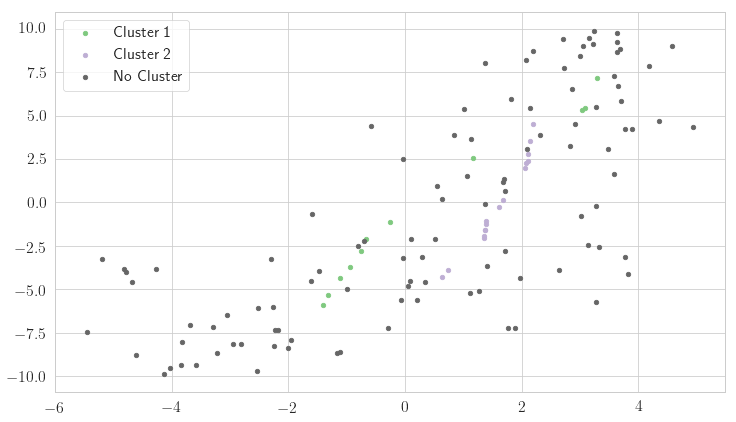

In [206]:
fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='upper left') 
# fig.savefig(f"figs/tsne_componnts_perp_30_colored_5_clique_directed.pdf")

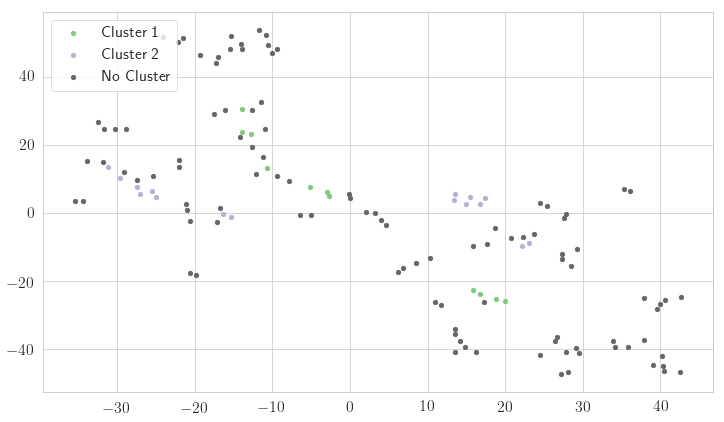

In [207]:
tsne = manifold.TSNE(perplexity=5)
data_tsne = tsne.fit_transform(clique_mode)

fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='upper right') 
# fig.savefig(f"figs/tsne_componnts_perp_30_colored_5_clique_directed.pdf")

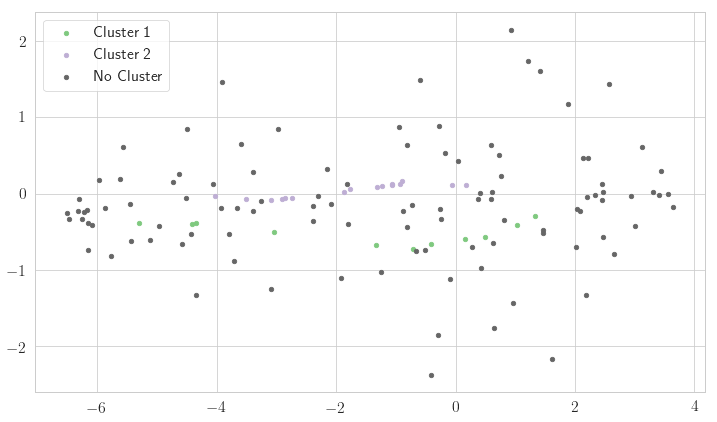

In [215]:
np.random.seed(1234567890)
tsne = manifold.TSNE(perplexity=55)
data_tsne = tsne.fit_transform(clique_mode) 

fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='upper left') 
# fig.savefig(f"figs/tsne_componnts_perp_30_colored_5_clique_directed.pdf")

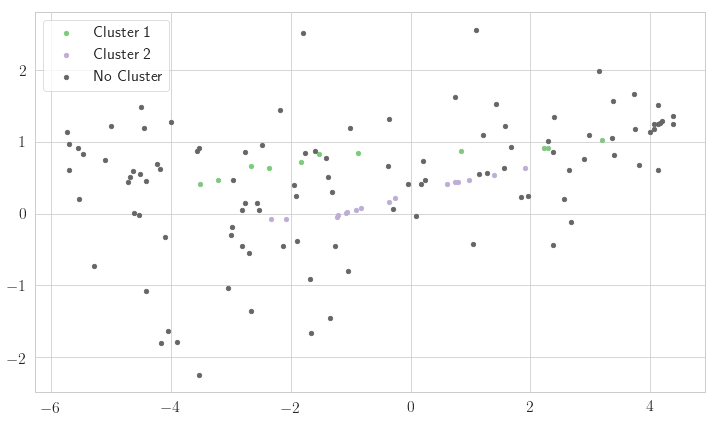

In [216]:
np.random.seed(1234567890)
tsne = manifold.TSNE(perplexity=55, method='exact')
data_tsne = tsne.fit_transform(clique_mode) 

fig, ax = plt.subplots()
for i in [0, 1]:
    ax.scatter(*data_tsne[clst == i].T, s=20, color=colorcycle[i], label=f"Cluster {i+1}") 
ax.scatter(*data_tsne[clst == -1].T, s=20, color=colorcycle[-1], label=f"No Cluster") 
ax.legend(loc='upper left') 
# fig.savefig(f"figs/tsne_componnts_perp_30_colored_5_clique_directed.pdf")